# Vanilla Neural Network from scratch

# Setup

## Packages

Import packages required throughout the notebook.

In [1]:
# Data packages
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image # To grab the images and extract useful information

# Various scoring metrics from sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# Other System packages 
import os 
np.random.seed(42) # Set random seed

## Data


Read in the labels and file information

In [2]:
# Set the dataset directory
dataset_dir = os.getcwd() + "/raw_data"

# Get the data labels
labels_file = dataset_dir + "/data_labels.csv"
data_labels = pd.read_csv(labels_file)

# How much data do we have?
print(data_labels.shape)

(4870, 2)


In [3]:
# Get X files
file_list = [dataset_dir + "/" + str(x) + ".png" for x in list(data_labels["id"])]

In [4]:
# Get the labels
data_labels["class"] = np.where(data_labels['label']=='automobile', 1, 0)
data_labels["class"].value_counts() # How many positive cases do we have?

0    4370
1     500
Name: class, dtype: int64

Data needs to be standardised to be between 0 and 1.  Since pixel colour values range from 0 - 255, they can be divided by 255 to rescale.

In [5]:
## TO DO ##

# Create a function that will standardise the dataset (Hint: What range are the possible values now?)
# Replace False

def standarise_data(dataset):
    
    # Convert RGB values from 0 - 255 to 0 - 1
    new_dataset = dataset / 255
    
    return new_dataset

In [6]:
## TO DO ##

# Create a function that will load and split the dataset
# Replace False

def load_data():
    
    global X_train, X_test, y_train, y_test
    
    X = np.array([np.array(Image.open(fname)) for fname in file_list])
    y = np.array(data_labels["class"])
    
    # TODO - here you need to split the dataset (use test_train_split). Let's use 30% for the test size.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    
    # Here is some reshaping code - don't need to worry about this
    # Though feel free to run different lines to see what is happening!
    y_train = y_train.reshape(1, y_train.shape[0])
    y_test = y_test.reshape(1, y_test.shape[0])
    
    # Reshape the training and test examples 
    X_train_f = X_train.reshape(X_train.shape[0], -1).T
    X_test_f = X_test.reshape(X_test.shape[0], -1).T
        
    ## TODO, call your standardisation function to standardize data to have feature values between 0 and 1.
    X_train = standarise_data(X_train_f)
    X_test = standarise_data(X_test_f)
    

    print ("Flatten X_train: " + str(X_train.shape))
    print ("Flatten X_test: " + str(X_test.shape))
    
    print ("y_train: " + str(y_train.shape))
    print ("y_test: " + str(y_test.shape))
    
    return X_train, X_test, y_train, y_test

# Classical ML Comparison

Note that the below is only for reference. It will likely take a LONG time to run. Hence only call this for exploratory purposes. Comment out the call below in future runs!

WARNING - THE CODE ALSO uses all CPU's except 1. Run at your own risk!

In [ ]:
def run_logistic():
    from sklearn.linear_model import LogisticRegressionCV 
    import datetime
    
    X_train_clf = X_train.T
    X_test_clf = X_test.T

    y_train_clf = y_train.T.ravel()
    y_test_clf = y_test.T.ravel()

    print(X_train_clf.shape, X_test_clf.shape, y_train_clf.shape, y_test_clf.shape)

    C_list = np.linspace(0.001, 0.5, 20)
    
    log_reg = LogisticRegressionCV(
        Cs=C_list, cv=10, penalty='l2', scoring='roc_auc', solver='liblinear', tol =1e-4, max_iter=1000, 
        class_weight='balanced', 
        n_jobs=os.cpu_count() - 1, 
        verbose=2, refit=True, multi_class='ovr', random_state=42
    )

    #Fit to our model
    start = datetime.datetime.now()
    log_reg.fit(X_train_clf, y_train_clf)
    end = datetime.datetime.now()
    
    print("Total time taken: {}".format(end - start))
    
    # Predict the class
    y_test_clf = pd.DataFrame(y_test_clf, columns=["actual"])
    y_test_clf["predictions_lr"] = log_reg.predict(X_test_clf)
    
    # Get confusion matrix 
    print("Confustion Matrix \n", confusion_matrix(y_test_clf.actual, y_test_clf.predictions_lr))

    # Get classification report
    print(classification_report(y_test_clf.actual, y_test_clf.predictions_lr))

    # Get ROC-AUC
    print("ROC-AUC Score \n", roc_auc_score(y_test_clf.actual, y_test_clf.predictions_lr))

    # Get accuracy
    print("Accuracy Score \n", accuracy_score(y_test_clf.actual, y_test_clf.predictions_lr))

In [ ]:
run_logistic()

# Network setup

## Network Architecture Dict

We will set up a dictionary that contains the architecture and elements for our model.  The model can be any number of layers, so only the number of layers and the first layer are defined in the dictionary.  All other layers will be added as the model is initialised.

In [7]:
def set_up_network():
    network_model = {
       'number_layers': '',
       'layer_1': {'W': '', 'b': '', 'Z': '', 'A': '', 'Activation': '', 'Vdw': '', 'Vdb': ''}
    }
    return network_model

## Initialization

Each layer of the model is initialised with:
- W - weights.  Various initialisations have been tried but the model is built based on He initialisation where the weights are multiplied by the square root of (2 / number of inputs to the layer).
- b - biases.  These are been initialised to 0
- Vdw - This is for Momentum optimisation to be applied to weights and is initialised to 0
- Vdb - This is the Momentum optimisation to be applied to biases and is initialised to 0
- Activation - This is the activation function to be applied to this layer.  This is specified individually for each layer when the model is run.

In [8]:
def initialise_layer(layer_number, network_model):
    
    np.random.seed(42)
    
    # You need to create a Weight matrix. 
    # We index into the layer_dimensions list to use numbers from there.
    w_matrix = np.random.randn(layer_dimensions[layer_number], layer_dimensions[layer_number-1]) * np.sqrt(2 / (layer_dimensions[layer_number-1]))
    #* np.sqrt(1 / (layer_dimensions[layer_number] + layer_dimensions[layer_number-1]))
    #* np.sqrt(2 / (layer_dimensions[layer_number-1]))

    # You need to create a Bias matrix
    b_matrix = np.zeros((layer_dimensions[layer_number], 1))
    
    # Now put those into our network model
    model_index = 'layer_' + str(layer_number) # This creates the index into our dictionary
    network_model[model_index] = {'W': '', 'b': '', 'Z': '', 'A': '', 'Activation': '', 'Vdw': '', 'Vdb': ''}
    network_model[model_index]['W'] = w_matrix # What variable would we store here?
    network_model[model_index]['Vdw'] = np.zeros((layer_dimensions[layer_number], layer_dimensions[layer_number-1]))
    network_model[model_index]['b'] = b_matrix # What variable would we store here?
    network_model[model_index]['Vdb'] = b_matrix # What variable would we store here?
    network_model[model_index]['Activation'] = activations[layer_number-1] # Activation are from layer 1 onwards
    
    return network_model
    

In [9]:
# Now let's call our function
def initialise_model(network_model):
    
    network_model['number_layers'] = len(layer_dimensions)-1
    # We only want to initialise the first three layers (not output)
    for index_num in range(len(layer_dimensions)-1):

        layer_number = int(index_num) + 1 # Beware python zero indexing!

        network_model = initialise_layer(layer_number, network_model)
    
    return network_model
    

# Forward prop

In this section we will create a series of functions that will:

* Undertake the linear multiplication
* Underake the activation of the layer
* Store this somewhere for efficient computation of backprop

## Linear Component

In [10]:
## TO DO ##

# Create a function that will undertake the linear component of forward prop
# Replace False

def linear_forward(A_prev, W, b):
    """
    Input:
    A_prev     -- activations from previous layer
    W          -- weights matrix
    b          -- bias vector

    Output:
    Z          -- the input to activation function 
    """
    
    Z = np.dot(W, A_prev) + b 
    
    return Z

## (Non-linear) Activations

4 non-linear activations are defined:

- Sigmoid which is used for the output layer to output a probability the image is a car or not. Formula is defined as:
\begin{equation*}
A = \frac{1}{1 + e^{-Z}}
\end{equation*}
- Relu (rectified linear unit): If Z is > 0 then it is Z else it is 0
- Leaky Relu is a variant on Relu that has a non-zero gradient when negative: If Z is > 0 then it is Z else it is alpha * Z
- Elu (Exponential Linear Unit) has an exponential value below 0: If Z is > 0 then it is Z else it will be alpha * (exp(Z) - 1)

Formulas are based on https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html

In [11]:
## TO DO ##

# Create a function that will undertake sigmoid activaiton
# Create another function that will undertake relu activation
# Replace False

def sigmoid(Z):
    """    
    Input:
    Z     -- numpy array of any shape
    
    Output:
    A     -- output of sigmoid(z)
    """
        
    A = 1./(1 + np.exp(-Z)) 
    
    return A

def relu(Z):
    """    
    Input:
    Z     -- numpy array of any shape
    
    Output:
    A     -- output of relu(z)
    """
    
    A = np.maximum(Z, 0)
    
    return A

def elu(alpha, Z):
    """    
    Input:
    alpha:  Constant to adjust negative numbers by
    Z     -- numpy array of any shape
    
    Output:
    A     -- output of relu(z)
    """
    
    A = np.where(Z> 0,Z,alpha * (np.exp(Z) - 1))
    
    return A

def leaky_relu(alpha, Z):
    """    
    Input:
    alpha:  Constant to adjust negative numbers by
    Z     -- numpy array of any shape
    
    Output:
    A     -- output of relu(z)
    """
    
    A = np.maximum(Z, alpha * Z)
    
    return A

## Complete Forward Prop


Forward propagation is handled below.  This will propagate through however many layers are in the model, applying a linear multiplication followed by the activation function that has been defined for that layer.

In [12]:
### TODO 

# Remember our network_model dictionary? Let's fill it for the forward pass
def forward_prop(X, network_model):

    # Layer n forward prop
    # Set some parameters here:
    for num in range(network_model['number_layers']):
    
       layer_number = num + 1 # Index starts at 0 but layers will be from 1
       model_index = 'layer_' + str(layer_number)
        
       if layer_number == 1: 
          A_prev = X # Use Actual values as input for first layer
       else:
          A_prev = network_model['layer_' + str(layer_number-1)]['A']

       l_W = network_model[model_index]['W'] # Where to get the weights matrix for this layer?
       l_b = network_model[model_index]['b'] # Where to get the bias matrix for this layer?

       # Now let's use them to create our Z and A
       network_model[model_index]['Z'] = linear_forward(A_prev=A_prev, W=l_W, b=l_b)
       if network_model[model_index]['Activation'] == 'relu':
          network_model[model_index]['A'] = relu(network_model[model_index]['Z'] ) # What activation function do we call here?
       elif network_model[model_index]['Activation'] == 'elu': 
          network_model[model_index]['A'] = elu(0.01, network_model[model_index]['Z'])
       elif network_model[model_index]['Activation'] == 'leaky relu': 
          network_model[model_index]['A'] = leaky_relu(0.01, network_model[model_index]['Z'])
       else:
          network_model[model_index]['A'] = sigmoid(network_model[model_index]['Z'] ) # What activation function do we call here?
    
    return network_model

# Cost function

The function calculates the cross-entropy loss with the formula:
$$cost = -1 * (Y * log(A Final) + (1 - Y) * log(1 - A Final))$$
Where A Final is the result from the final layer which was a sigmoid function.

This is then averaged by dividing by the number of samples.

In [13]:
## TO DO ##

# Write a function to compute the binary logistic cost function ('cross entropy loss')
# This is on the slides from block_1. 
# Beware of correct dimensions for matrix calculations to work
# Replace False

def compute_cost(A_final, Y):
    """
    Input:
    A_final    -- probability vector for label predictions (Output of last layer activation)
    Y          -- truth vector vector

    Output:
    cost       -- cost
    """
    
    m = Y.shape[1] # How many samples are there? Needed to average our loss.
    
    cost_total = -1 * np.sum(np.dot(Y, np.log(A_final).T) + np.dot(1 - Y, np.log(1 - A_final).T))
    cost = (1./m) * cost_total  # Take an average
    
    return cost

# Back prop

Firstly initialise a gradients dictionary.  Only the dA_Cost element is initialised and then layers will be added dynamically depending on how many layers there are.

In [14]:
def initialise_gradients():
    gradients = {
        'dA_cost': ''
    }
    return gradients

## Differentiate Cost

The formula for differentiating the cost is
\begin{equation*}
dA = \frac{-Y}{A final}+\frac{(1-Y)}{(1 - A final)}
\end{equation*}

In [15]:
# We firstly need to differentiate the loss w.r.t to the final activation layer
# TODO
# Replace False

def differentiate_cost(A_final, Y):
    """
    Input:
    A_final          -- Final output of last activation in the network
    Y                -- Truth Vector

    Output:
    dA_cost          -- Gradient of the cost w.r.t activation of last layer
    """

    dA_cost = -Y / A_final + ((1-Y) / (1-A_final))

    return dA_cost

## Differentiate Linear

In [16]:
# You do not need to do anything here, but notes are included for your interest

def linear_backward(dZ, A_prev, W, b):
    """
    Input:
    dZ            -- Gradient of the cost w.r.t 'Z' of current layer
    A_prev, W, b  --  from forward-prop in the current layer, we stored this in our forward network

    Output:
    dA_prev       -- Gradient of the cost w.r.t activation of previous layer
    dW            -- Gradient of the cost w.r.t W of current layer
    db            -- Gradient of the cost w.r.t b of current layer
    """
    
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

## Differentiate Activations

Each Activation function must also be differentiated so there are differentiation routines for

- Relu - if the Z value is greater than 0 then dz will be dA, else it will be 0
- Elu - if the Z value is greater than 0 then dz will be dA, else it will be dA * alpha * exp(Z)
- Leaky Relu - if the Z value is greater than 0 then dz will be dA, else it will be dA * alpha
- Sigmoid:  $$dZ = dA * \sigma(Z)*(1 - \sigma(Z)) $$

Formulas are based on https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html

In [17]:
## TO DO ##

# Differentiate the relu and the sigmoid functions
# Replace False

def relu_backward(dA, Z):
    """
    Input:
    dA      -- post-activation gradient
    Z       -- 'Z' that was used in the forwards prop

    Output:
    dZ      -- Gradient of the cost with respect to Z
    """

    dZ = dA * (Z > 0) * 1
        
    return dZ

def sigmoid_backward(dA, Z):
    
    """
    Input:
    dA      -- post-activation gradient
    Z       -- 'Z' that was used in the forwards prop

    Returns:
    dZ      -- Gradient of the loss with respect to Z
    """
    A = sigmoid(Z)
    dZ = dA * A * (1 - A)
        
    return dZ

def elu_backward(alpha, dA, Z):
    """    
    Input:
    alpha:  Constant to adjust negative numbers by
    dA      -- post-activation gradient
    Z       -- 'Z' that was used in the forwards prop
    
    Output:
    dZ      -- Gradient of the loss with respect to Z
    """
    
    dZ = dA * np.where(Z> 0,1,alpha * np.exp(Z))
    
    return dZ

def leaky_relu_backward(alpha, dA, Z):
    """    
    Input:
    alpha:  Constant to adjust negative numbers by
    dA      -- post-activation gradient
    Z       -- 'Z' that was used in the forwards prop
    
    Output:
    dZ      -- Gradient of the loss with respect to Z
    """
        
    dZ = dA * np.where(Z> 0,1,alpha)
    
    return dZ

## Complete backwards

For each layer, backward propagation is appled to determine the gradients for each neuron.  This procedure will apply back propagation to however many layers are in the model and call the relevant activation differentiation function for that layer.  The gradients for each layer are then set, ready to be updated back to the weights.

In [18]:
def backprop(X, network_model, gradients):
    # We have differentiated A_Final w.r.t the loss

    # When differentiating, we need to use our forward-prop data (Z, W, b)
    for layer_number in range(network_model['number_layers'], 0, -1):
        model_index = 'layer_' + str(layer_number)
    
        Z_curr = network_model[model_index]['Z']
        W_curr = network_model[model_index]['W']
        b_curr = network_model[model_index]['b']
        if layer_number == 1:
            A_prev = X
        else:
            A_prev = network_model['layer_' + str(layer_number-1)]['A']
    
        # Rolling back one level, we need to differentiate the last activation (sigmoid) and then the linear component
        if network_model['number_layers'] == layer_number:
            gradient_model = 'dA_cost'
        else:
            gradient_model = 'dA' + str(layer_number)
            
        # Decide which differentiation to perform based on Activation
        if network_model[model_index]['Activation'] == 'relu': 
           dZ_curr = relu_backward(dA = gradients[gradient_model], 
                                           Z = Z_curr)
        elif network_model[model_index]['Activation'] == 'elu': 
           dZ_curr = elu_backward(alpha=0.01, dA = gradients[gradient_model], 
                                           Z = Z_curr)
        elif network_model[model_index]['Activation'] == 'leaky relu': 
           dZ_curr = leaky_relu_backward(alpha=0.01, dA = gradients[gradient_model], 
                                           Z = Z_curr)
        else:
           dZ_curr = sigmoid_backward(dA = gradients[gradient_model], 
                                        Z = Z_curr)

        #print ("dZ_3: {} {} {}".format(dZ_3[0,0], gradients['dA_cost'][0,0], Z_3[0,0]))

        # Now we need to differentiate the linear part
        dA_prev, dW_curr, db_curr = linear_backward(dZ = dZ_curr, 
                                       A_prev = A_prev, 
                                       W = W_curr, 
                                       b = b_curr
                                       )

        # Let's put those into our gradients store!
        gradients['dA' + str(layer_number-1)] = dA_prev
        gradients['dW' + str(layer_number)] = dW_curr
        gradients['db' + str(layer_number)] = db_curr
    
    return network_model, gradients

# Update Parameters

Here we want to use our gradients to update our parameters. Undertaking gradient descent!

Momentum Optimisation has been applied to the model, to take into account previous epochs.  This can smooth out gradient descent and lead to faster training.  A beta co-efficient is passed in to control the amount of momentum used.  If it is 0, then no momentum is applied and it is just the normal gradient descent.

Once the gradients have been updated through back propagation, the weights and biases are updated by a gradient step.  The step goes in the opposite direction to the gradient hence why the gradient step is multiplied by -1.  The size of the step is dependent on the learning rate.

In [19]:
## TO DO ##

# Update each parameter
# Remember what hyperparameter is important for this step?
# You will also find a useful, indexed value in the 'grads' dictionary created in backprop above
# Replace False

def update_parameters(network_model, gradients, learning_rate, beta):
    
    # Let's update our W and B matrixes using the gradients
    for key, val in network_model.items():
        if key != 'number_layers':  # ignore number_layers network model
            layer_number = key.split("layer_",1)[1] # get layer number after _
            network_model[key]['Vdw'] = beta * network_model[key]['Vdw'] + (1 - beta) * gradients['dW' + str(layer_number)]
            network_model[key]['Vdb'] = beta * network_model[key]['Vdb'] + (1 - beta) * gradients['db' + str(layer_number)]
            gradient_step_W = -1 * (learning_rate * network_model[key]['Vdw'])
            gradient_step_b = -1 * (learning_rate * network_model[key]['Vdb'])
            # Now take the steps!
            network_model[key]['W'] = network_model[key]['W'] + gradient_step_W # Hint: When taking a step, where do you start - and how do you step?
            network_model[key]['b'] = network_model[key]['b'] + gradient_step_b
    
    # Now let's return our updated model
    
    return network_model

# Put it all together

This function will create the model, and run through the number of epochs of the training phase.  The function is passed:

- The learning rate to be applied for gradient descent
- The number of epochs to run through when training the model
- the activation function that will be applied for each layer
- the beta co-efficient for Momentum Optimisation (if none passed, will be 0 so there will be no Momentum)

In [20]:
def run_model(learning_rate, num_iter, activations, beta=0.0):
    
    # Set up some parameters
    np.random.seed(42)
    costs = {'Cost': [], 'Iteration': []}
    
    # Read in data
    X_train, X_test, y_train, y_test = load_data()
    
    # Set up the model
    network_model = set_up_network()
    network_model = initialise_model(network_model)
        
    # Run the training n times
    for x in range(num_iter):
        # Run Forward Prop
        
        network_model = forward_prop(X_train, network_model) # Do all layers Forward Propagation

        # Cost Function
        cost = compute_cost(A_final= network_model['layer_' + str(len(activations))]['A'], 
                            Y = y_train
                           )
        costs['Cost'].append(cost)
        costs['Iteration'].append(x+1)
    
        # Print the cost every 50 epoch
        if x % 50 == 0:
            print ("Cost after iteration {} is {}".format(x+1, cost))
     
        # Backprop
        gradients = initialise_gradients() # How do we set up gradient dictionary?

        # Differentiate the cost function
        gradients['dA_cost'] = differentiate_cost(A_final = network_model['layer_' + str(len(activations))]['A'], 
                                                  Y = y_train)

        # Run backprop
        network_model, gradients = backprop(X_train, network_model, gradients)

        # Update parameters
        network_model = update_parameters(network_model, gradients, learning_rate, beta)
        
    print ("Cost after iteration {} is {}".format(x+1, cost)) # Do final print to show end result
    print("Accuracy: ", accuracy_score(y_pred=np.where(network_model['layer_' + str(len(activations))]['A'][0]>0.5, 1,0),y_true=y_train[0]))
        
    return costs, network_model, gradients

# Predict (Hold out)

Once the model has finished it's learning cycle, it can then be used to calculate probabilities.  This is then turned into a classification (above 0.5 is a car).

In [38]:
## TO DO ##

# Create your own predict function.
# Note the number of training examples
# Turn the probabilities into 0-1 predictions
# Replace False

def predict(X, y, parameters):
    
    """ 
    Input:
    X           -- data (test set)
    parameters  -- parameters of the trained model
    
    Output:
    p -- predictions for the given dataset X
    
    """
    
    m = X.shape[1] # How many examples?
    p = np.zeros((1,m)) # Initialise probabilities to zero
 
    # Forward propagation with our test set
    network_model_t = forward_prop(X, parameters)
    
    # Extract probabilities - where are these?
    probas = network_model_t['layer_' + str(network_model_t['number_layers'])]['A']
    
    # Make a dataframe to generate metrics easily
    results = pd.DataFrame({'probas':probas[0], 'truth':y[0]})
    results['class'] = np.where(results.probas>0.5, 1,0)
    
    return results

# Running the Model

The model is run calling **run_model** and specifying:

- The learning rate
- The number of iterations (or epochs) to perform
- The layer dimensions.  The number of hidden layers can be changed
- The Activation function to apply to each hidden layer and output layer.  So there will be 1 less element for activations compared to the layer dimensions as the input layer has no activation.
- The beta co-efficient for calculating Momentum Optimisation 

The accuracy of the training data as well as the final cost attained is printed at the end.  Then, a plot of the costs is then output at the end.

Flatten X_train: (3072, 3409)
Flatten X_test: (3072, 1461)
y_train: (1, 3409)
y_test: (1, 1461)
Cost after iteration 1 is 0.48920612331787783
Cost after iteration 51 is 0.291097903990637
Cost after iteration 101 is 0.26266061230866555
Cost after iteration 151 is 0.24368266161574306
Cost after iteration 201 is 0.23003598792514113
Cost after iteration 251 is 0.2192786945877137
Cost after iteration 301 is 0.21011543797610815
Cost after iteration 351 is 0.20182449274034905
Cost after iteration 401 is 0.19435203953726238
Cost after iteration 451 is 0.18731469022023883
Cost after iteration 501 is 0.1806578480064814
Cost after iteration 551 is 0.17432199194684286
Cost after iteration 601 is 0.16828493739199923
Cost after iteration 651 is 0.16248021050087344
Cost after iteration 701 is 0.15684978759045565
Cost after iteration 751 is 0.15130698644210192
Cost after iteration 801 is 0.14592703226283527
Cost after iteration 851 is 0.1406779093323645
Cost after iteration 901 is 0.13554266367069112


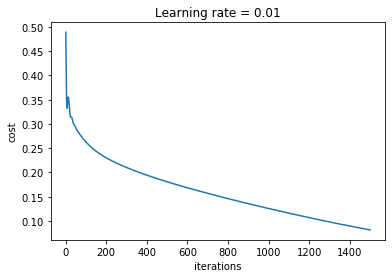

In [28]:
np.random.seed(42) # Set random seed
learning_rate = 0.01
num_iter = 1500
layer_dimensions = [3072, 1000, 800, 100, 1]
activations = ['elu', 'elu', 'elu', 'sigmoid']
beta = 0.9
costs, network_model, gradients = run_model(learning_rate , num_iter, activations, beta)

# Let's plot the cost
costs_df = pd.DataFrame(costs)
plt.plot(costs_df['Iteration'],costs_df['Cost'])
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate = " + str(learning_rate))
plt.show()

Finally, predict on the held out test and:

- Plot the probabilities for each image (coloured by its true class - car or not car)
- Display the confusion matrix and accuracy statistics

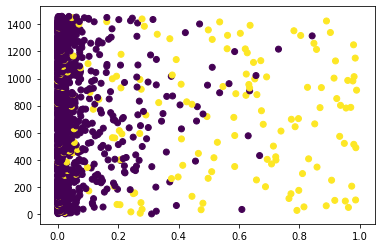

Confusion Matrix 
 [[1286   11]
 [  85   79]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1297
           1       0.88      0.48      0.62       164

    accuracy                           0.93      1461
   macro avg       0.91      0.74      0.79      1461
weighted avg       0.93      0.93      0.93      1461

Accuracy:  0.9342915811088296
ROC_AUC:  0.900901705624612


In [40]:
# Create some predictions
results = predict(X_test, y_test, network_model)

# Make a scatter plot of probabilities. Good check if something is wrong
# Colour by the true value of car or not
plt.scatter(x=results['probas'], y=results.index, c=results['truth'])
plt.savefig('scatter.jpg')
plt.show()

# Check your prediction value counts
results['class'].value_counts()

# Build some sklearn scores

#Get confusion matrix 
print("Confusion Matrix \n", confusion_matrix(y_pred=results['class'],y_true=results['truth']))

#Get classification report
print(classification_report(y_pred=results['class'],y_true=results['truth']))

# Accuracy score
print("Accuracy: ", accuracy_score(y_pred=results['class'],y_true=results['truth']))

# ROC_AUC score
print("ROC_AUC: ", roc_auc_score(y_score=results['probas'],y_true=results['truth']))


Now, display the False Positive images - those misclassified as cars

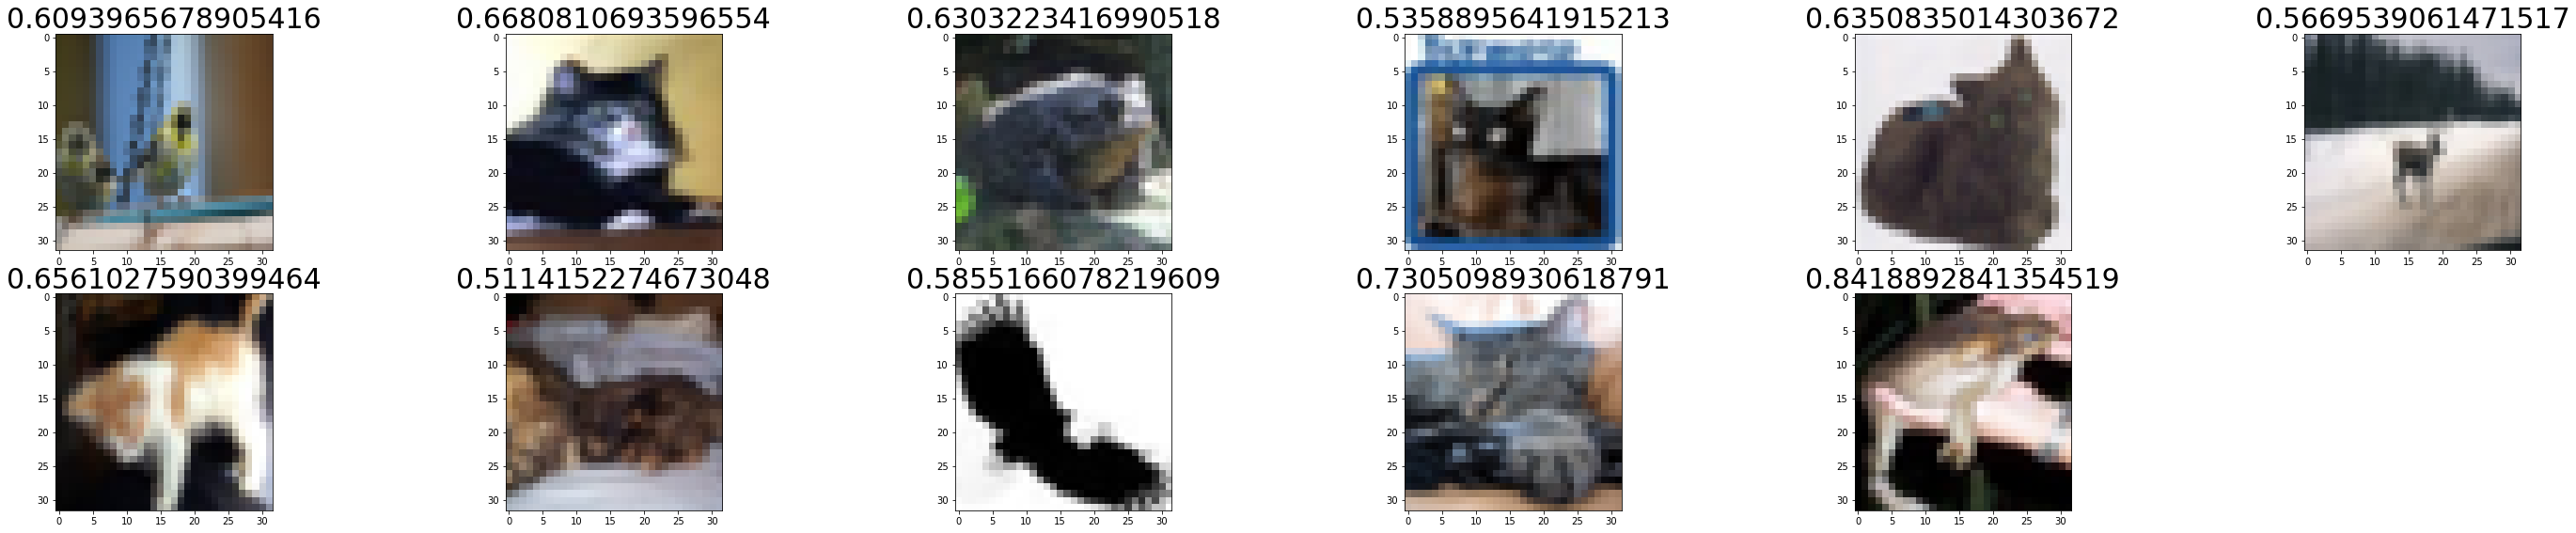

In [30]:
dfa = results[(results['class'] ==1) &  (results['truth']==0)]
X_test_t = X_test.T
X_test_t = X_test_t.reshape(X_test_t.shape[0], 32, 32, 3)
plt.figure(figsize=(50,50))
i = 0
for index, row in dfa.iterrows():
    i += 1

    plt.subplot(10,6,i)    # the number of images in the grid
    plt.gca().set_title(row.probas, size=30)
    plt.imshow(X_test_t[index])

plt.show()

Then display the False Negatives - cars misclassified as not cars

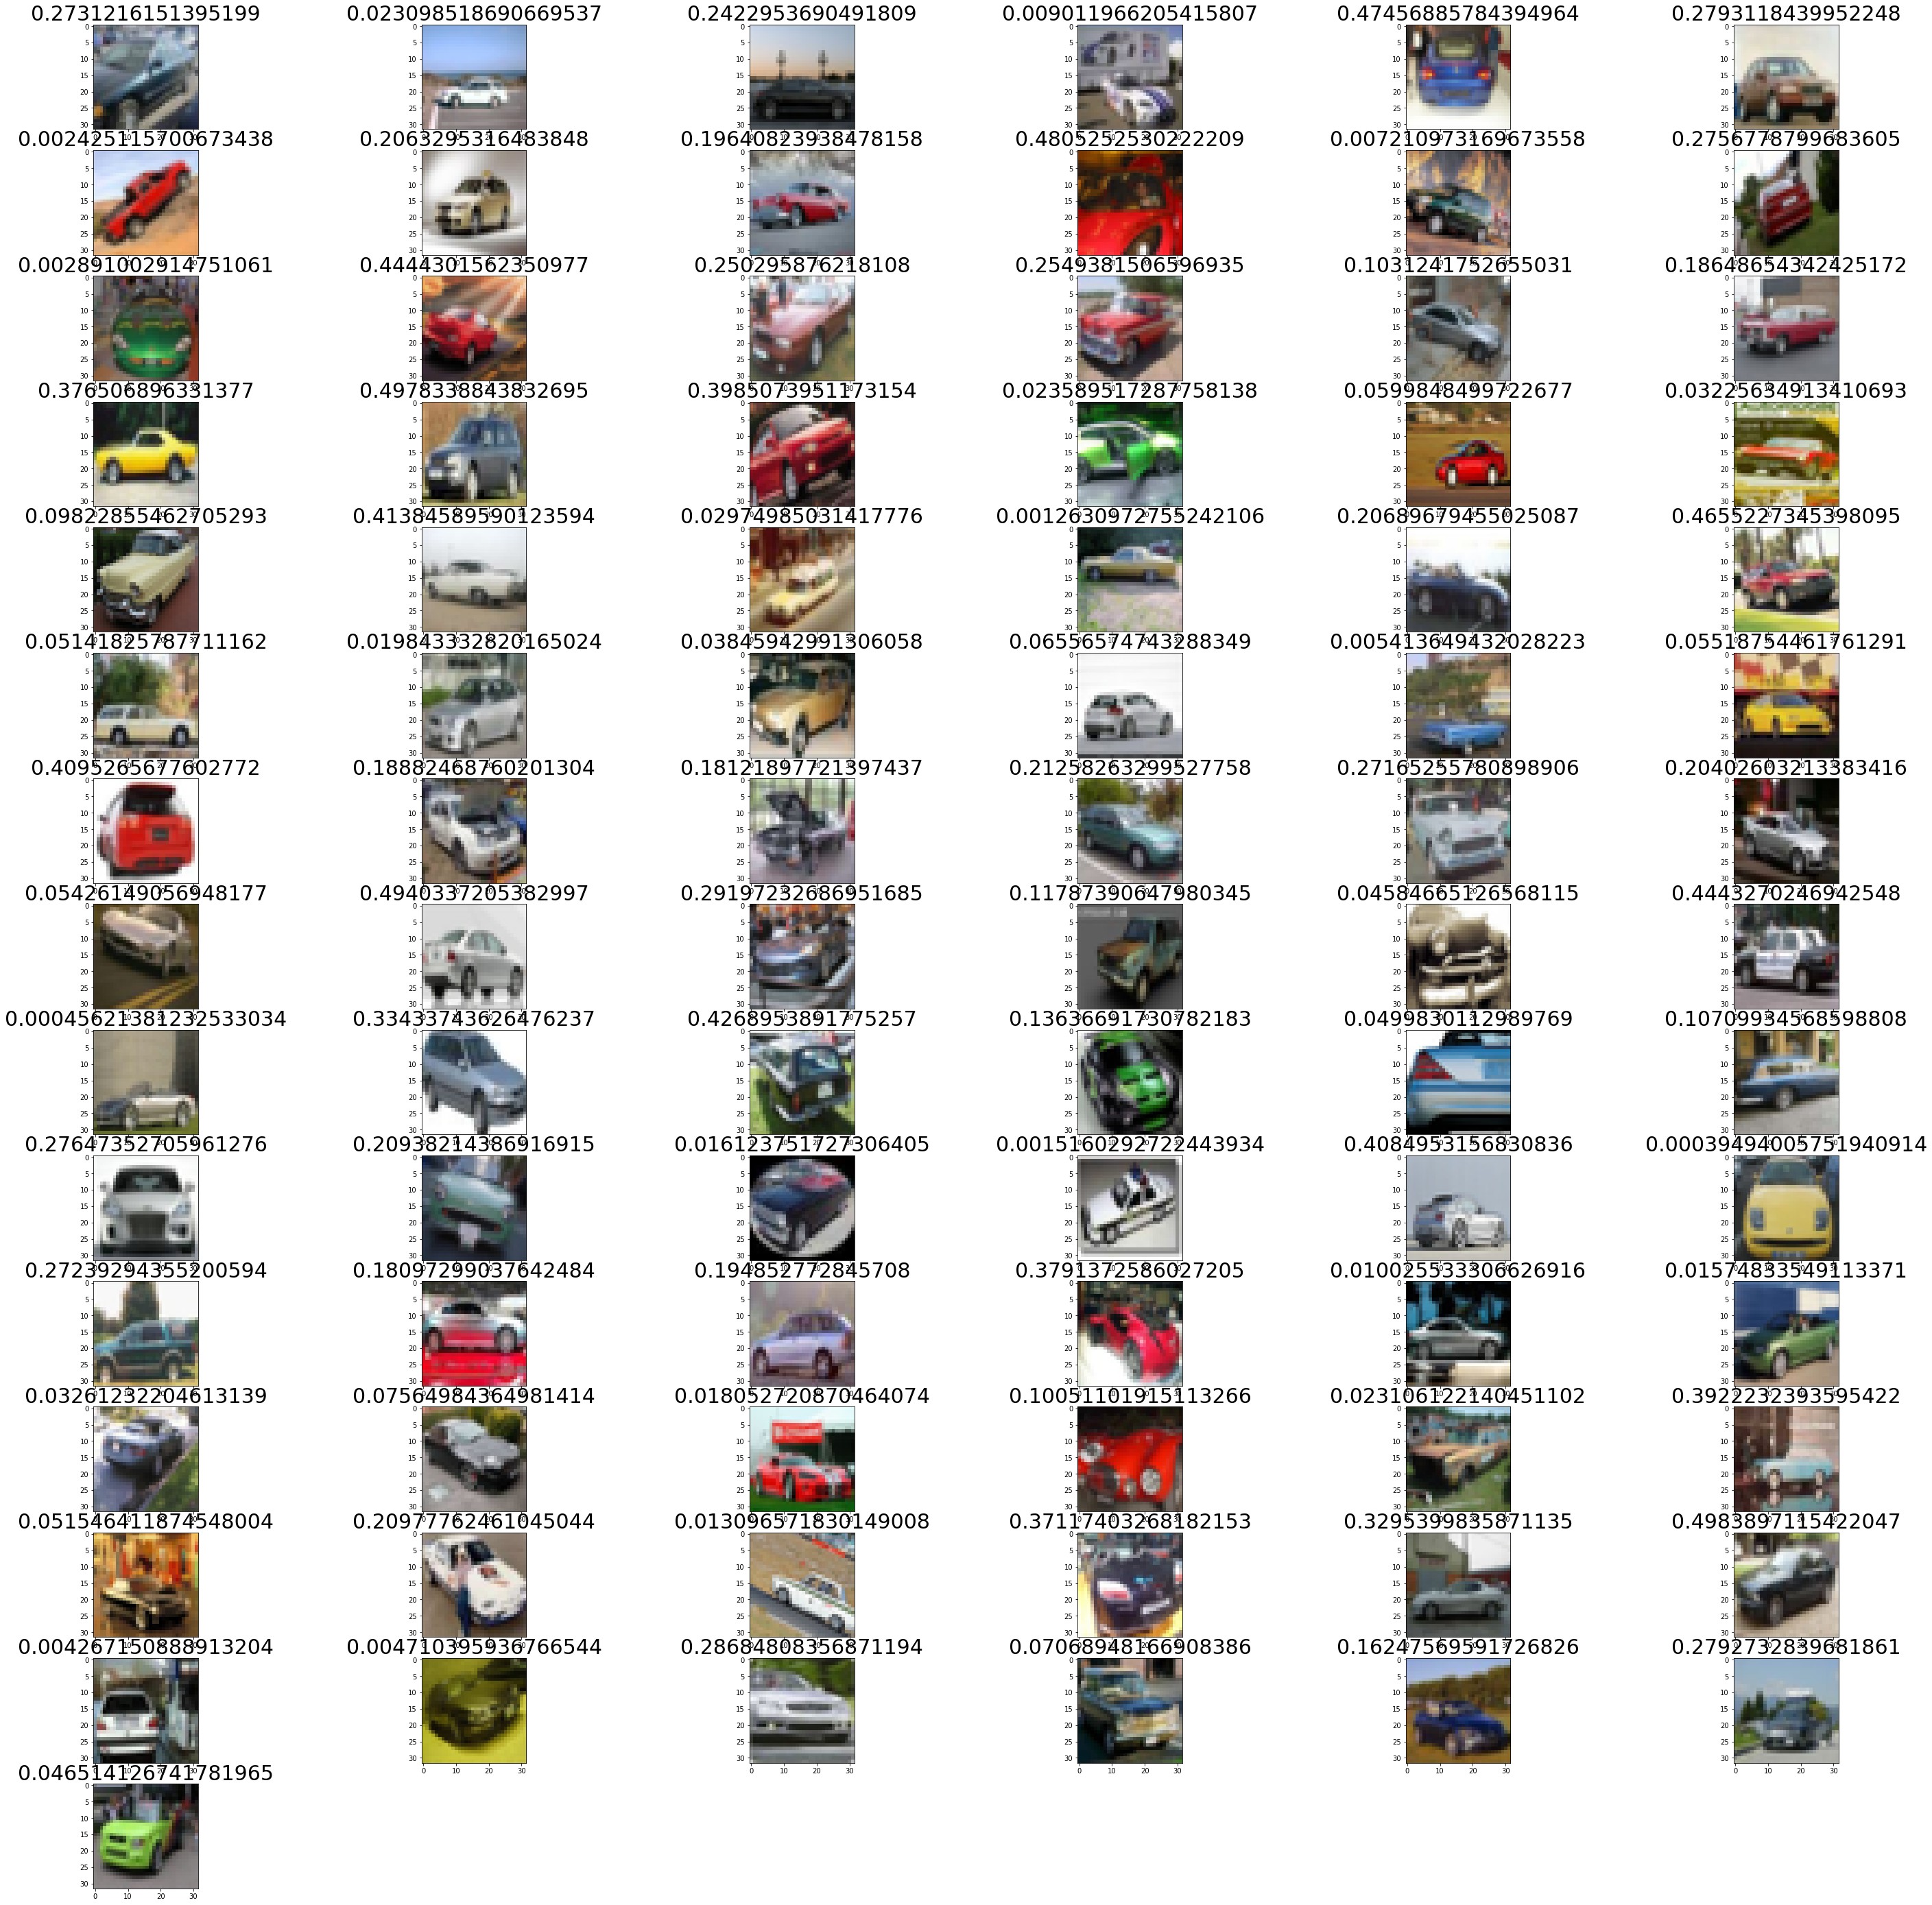

In [31]:
dfb = results[(results['class'] ==0) &  (results['truth']==1)]
X_test_t = X_test.T
X_test_t = X_test_t.reshape(X_test_t.shape[0], 32, 32, 3)
plt.figure(figsize=(50,50))
i = 0
for index, row in dfb.iterrows():
    i += 1

#for i in range(27):
    plt.subplot(15,6,i)    # the number of images in the grid is 5*5 (25)
    plt.gca().set_title(row.probas, size=30)
    plt.imshow(X_test_t[index])

plt.show()

Finally, below will print out images classified correctly as cars.

In [ ]:
dfc = results[(results['class'] ==1) &  (results['truth']==1)]
X_test_t = X_test.T
X_test_t = X_test_t.reshape(X_test_t.shape[0], 32, 32, 3)
plt.figure(figsize=(50,50))
i = 0
for index, row in dfc.iterrows():
    i += 1
    if i < 60:

       plt.subplot(10,6,i)    # the number of images in the grid is 5*5 (25)
       plt.gca().set_title(row.probas, size=30)
       plt.imshow(X_test_t[index])

plt.show()

# Experimentation

The original model with 10 and 8 hidden layers running Relu Activation got an accuracy of about 92% when run for 4,000 epochs.  The model tended to become unstable after that with the cost dithering about 0.13.  The parameters to run the original model is:

- learning_rate = 0.01
- num_iter = 4000
- layer_dimensions = [3072, 10, 8, 1]
- activations = ['relu', 'relu', 'sigmoid']
- beta = 0.0

When implementing Momentum and deeper layers, the cost tends to keep decreasing so does not suffer from the instability of the original model.  This can lead to overfitting though as the accuracy on the training set approaches 100% without an increase in accuracy on the hold out data.

For initialisation of weights, Xavier initialisation and He initialisation were implemented.  He tended to give a faster learning and so less epochs were needed.  As well, the following activiations were implemented:

- Leaky Relu
- Exponential Linear Units (ELU)

Leaky Relu, Elu and Relu have been used in various configurations.  They all perform similarly with elu showing perhaps a slight improvement.  The final model built above had:
- 1500 Epochs
- 1st hidden layer 1,000 nodes and activation of Elu
- 2nd hidden layer 800 nodes and activation of Elu
- 3rd hidden layer 100 nodes and activation of Elu
- Output layer 1 node and activation of Sigmoid

Number of neurons was based on https://www.heatonresearch.com/2017/06/01/hidden-layers.html, recommending number of neurons is less than two thirds of the input layer and output layer. 

This gave an accuracy of 93.4%, included in the final report.  Looking above at the mis-categorised images, False Positives were either busy images that was not clearly one thing (eg, nulti-coloured cat) or quite blocky colours (Black eagle).

Cars that were not categorised as such often were at an angle, had a large background component or was a partial image. 

Depending on the goal of the car park automation, the probability threshold could be adjusted to allow more cars to be identified at the expense of more false positives.  For the final model, a threshold of 0.4 (instead of 0.5) increased the accuracy to 93.6% and also increased the recall to 55%.